# Searchlight Analysis

Characterize problem and solution here. Need: experiment design, summary of each section. 

## Setup

In [1]:
import warnings
warnings.filterwarnings('ignore')

import nibabel as nib
import numpy as np
import brainiak
import os
import json
import seaborn as sns
import _pickle as cPickle
import matplotlib.pyplot as plt
import analysis_helpers as helpers
from nilearn import image
from numpy import shape
from brainiak.searchlight.searchlight import Searchlight
from brainiak.searchlight.searchlight import Diamond
from sklearn.metrics.pairwise import pairwise_distances as pd
from timeit import default_timer as timer

In [2]:
# load in experimental design pickle file
with open('morph_drawing_training_design.pkl', 'rb') as f:
    mdtd = cPickle.load(f, encoding='latin1') 

In [3]:
## cope numbering legend
## cope1 = 'bed'
## cope2 = 'bench'
## cope3 = 'chair'
## cope4 = 'table'

cope2obj = {'cope1':'bed','cope2':'bench', 'cope3':'chair','cope4':'table'}
obj2cope = {'bed':1,'bench':2, 'chair':3,'table':4}

In [4]:
# behavioral data from database
with open('versionNums.json') as json_data:
    coll = json.load(json_data)

In [5]:
## get list of subject directories
proj_dir = '/home/jefan/sketchloop02/'
contents_dir = os.listdir(proj_dir)

sub_dirs = []
for i in contents_dir:
    try:
        if i.split('_')[1]=='neurosketch':
            sub_dirs.append(i)
    except:
        pass

sub_dirs = sorted(sub_dirs)

# issue with 1207161
sub_dirs = [s for s in sub_dirs if s != '1207161_neurosketch']

# issue with 1201161
sub_dirs = [s for s in sub_dirs if s != '1201161_neurosketch']

print(sub_dirs)
print(str(len(sub_dirs)) + ' subjects')

['0110171_neurosketch', '0110172_neurosketch', '0111171_neurosketch', '0112171_neurosketch', '0112172_neurosketch', '0112173_neurosketch', '0113171_neurosketch', '0115172_neurosketch', '0115174_neurosketch', '0117171_neurosketch', '0118171_neurosketch', '0118172_neurosketch', '0119171_neurosketch', '0119172_neurosketch', '0119173_neurosketch', '0119174_neurosketch', '0120171_neurosketch', '0120172_neurosketch', '0120173_neurosketch', '0123171_neurosketch', '0123173_neurosketch', '0124171_neurosketch', '0125171_neurosketch', '0125172_neurosketch', '1121161_neurosketch', '1130161_neurosketch', '1202161_neurosketch', '1203161_neurosketch', '1206161_neurosketch', '1206162_neurosketch', '1206163_neurosketch', '1207162_neurosketch']
32 subjects


In [6]:
## Analysis helper functions (see and update: analysis_helpers.py)
def getEndpoints(morphline):
    # return two components 
    if morphline=='sedanMinivan':
        return ['sedan','minivan']
    elif morphline=='minivanSportscar':
        return ['minivan','sportscar']
    elif morphline=='sportscarSUV':
        return ['sportscar','SUV']
    elif morphline=='SUVMinivan':
        return ['SUV','minivan']
    elif morphline=='sportscarSedan':
        return ['sportscar','sedan']
    elif morphline=='sedanSUV':
        return ['sedan','SUV']
    elif morphline=='bedChair':
        return ['bed','chair']
    elif morphline=='bedTable':
        return ['bed','table']
    elif morphline=='benchBed':
        return ['bench','bed']
    elif morphline=='chairBench':
        return ['chair','bench']
    elif morphline=='chairTable':
        return ['chair','table']
    elif morphline=='tableBench':
        return ['table','bench']
    elif morphline=='limoToSUV':
        return ['limo','SUV']    
    elif morphline=='limoToSedan':
        return ['sedan','limo']  
    elif morphline=='limoToSmart':
        return ['limo','smartcar']  
    elif morphline=='smartToSedan':
        return ['smartcar','sedan']    
    elif morphline=='suvToSedan':
        return ['SUV','sedan']  
    elif morphline=='suvToSmart':
        return ['SUV','smartcar']  
    else:
        return ['A','B']

def get_mask_array(mask_path):
    # loads mask applied to nifty (.nii.gz) file
    # mask selects voxels to be included/discarded
    mask_img = image.load_img(mask_path)
    mask_data = mask_img.get_data()
    num_brain_voxels = sum(sum(sum(mask_data==1)))
    return mask_data, num_brain_voxels

def load_roi_mask_combined(subj,run_num,roi):
    if run_num in [1,2]:
        phase_num = '12' 
    elif run_num in [3,4]:
        phase_num = '34'
    elif run_num in [5,6]:
        phase_num = '56'
    mask_path = proj_dir + '/' + subj +'/analysis/firstlevel/rois/' + roi + '_func_combined_' + phase_num + '_binarized.nii.gz'        
    mask_data, nv = get_mask_array(mask_path)
    return mask_data

def load_single_run_weights(subj,run_num,cope_num):
    nifti_path = proj_dir + '/' + subj + '/analysis/firstlevel/glm4_recognition_run_' + str(run_num) + \
                '.feat/stats/' + 'cope' + str(cope_num) + '.nii.gz'
    fmri_img = image.load_img(nifti_path)
    fmri_data = fmri_img.get_data()
    return fmri_data, fmri_img.affine

def get_condorder(this_sub):
    versionNum = coll[this_sub]

    design = [i for i in mdtd if i['version'] == int(versionNum)] # find which axes belong to which condition
    trained = design[0]['trained']
    near = design[0]['near']

    Tep = getEndpoints(trained)
    Nep = getEndpoints(near)
    condorder = Tep + Nep

    return (obj2cope[condorder[0]],
            obj2cope[condorder[1]],
            obj2cope[condorder[2]],
            obj2cope[condorder[3]])

## Analysis / Data Collection
How searchlight works with brainiak:

1. Initiate a searchlight object, articulating certain parameters (e.g., searchlight shape, radius, max edge length, in voxels, of the 3D block(?)).
2. Distribute to the searchlight object, sorting between MPI ranks (?).
3. Broadcast data, i.e., define other variables to be available for each execution of the searchlight function.
4. Run the searchlight, this time articulating as a parameter the function to be applied at each searchlight location.

In [7]:
# some global parameters
num_copes = 4
num_runs = 2
null_mask = np.ones((94, 94, 72))
SAVE_PATH = 'searchlight_output_nii'

In [8]:
# function to operate over every searchlight region
# collects similarities between (btw) and within (wit) object categories
def compare_btw_wit_obj_similarity_across_runs(subject_data, mask, sl_rad, bcast_var):
    
    # reshape to 3D so old code can be reused
    for i in range(len(subject_data)):
        shaping = shape(subject_data[i])
        subject_data[i] = np.reshape(subject_data[i], (shaping[0], shaping[1], shaping[2]))
    
    # stack by cope for each run like roi-based function did, and then stack runs
    mat1 = np.vstack((subject_data[0].ravel(),
                     subject_data[1].ravel(),
                     subject_data[2].ravel(),
                     subject_data[3].ravel()))
    mat2 = np.vstack((subject_data[4].ravel(),
                      subject_data[5].ravel(),
                      subject_data[6].ravel(),
                      subject_data[7].ravel()))
    fAB = np.vstack((mat1, mat2))
    
    # take pairwise distance matrix life the roi-based function did and store summary statistics
    DAB = pd(fAB, metric='correlation')
    offblock = DAB[:len(mat1),range(len(mat1),shape(DAB)[1])]
    wit_obj = DAB[:len(mat1),range(len(mat1),shape(DAB)[1])].diagonal()
    btw_obj = np.hstack((offblock[np.triu_indices(shape(offblock)[0],k=1)],
                         offblock[np.tril_indices(shape(offblock)[0],k=-1)]))
    wit_mean = np.mean(wit_obj)
    btw_mean = np.mean(btw_obj)
    return btw_mean-wit_mean

In [9]:
# function that sets up and organizes searchlight over a set of subjects
def searchlight_over_each(subjects, sl_rad):
    
    for s in subjects:
        print(s)
        
        # set up searchlight object
        sl = Searchlight(sl_rad=sl_rad, shape=Diamond)
        
        # arrange data to be distributed to searchlight
        # list of 4D not 3D arrays
        subject_data = []
        for run in range(1, num_runs+1):
            for cope in get_condorder(s):
                weights, affine = load_single_run_weights(s, run, cope)
                subject_data.append(np.reshape(np.array(weights), (94, 94, 72, 1)))

        # distribute and broadcast needed data to searchlight
        sl.distribute(subject_data, null_mask)
        sl.broadcast(None)
        
        # run searchlight
        subject_outputs = np.array(sl.run_searchlight(compare_btw_wit_obj_similarity_across_runs))
        
        img = nib.Nifti1Image(subject_outputs.astype(np.float32), affine)
        # store output for this subject
        if not os.path.exists(SAVE_PATH):
            os.makedirs(SAVE_PATH)
        nib.save(img, os.path.join(SAVE_PATH, s + 'searchlight.nii.gz'))

In [ ]:
# run searchlight over all subjects and print time to compute results
start = timer()
searchlight_over_each(sub_dirs, 1)
end = timer()
print('time to run searchlight:', end - start)

0110171_neurosketch
0110172_neurosketch
0111171_neurosketch
0112171_neurosketch
0112172_neurosketch
0112173_neurosketch
0113171_neurosketch
0115172_neurosketch
0115174_neurosketch
0117171_neurosketch
0118171_neurosketch
0118172_neurosketch
0119171_neurosketch
0119172_neurosketch
0119173_neurosketch
0119174_neurosketch
0120171_neurosketch
0120172_neurosketch
0120173_neurosketch
0123171_neurosketch
0123173_neurosketch
0124171_neurosketch
0125171_neurosketch


## Results / Visualization

### What's the distribution of the values extracted via our searchlight?

#### Findings for an arbitrary subject:

histograms for a *single* subject
btw-wit


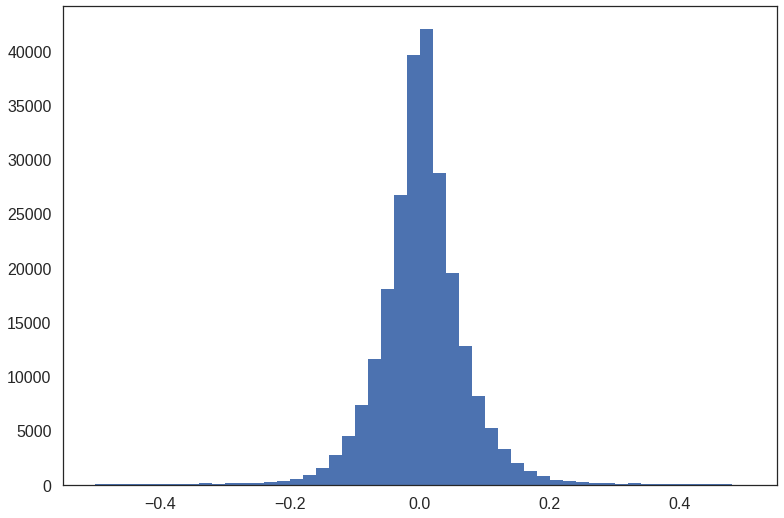

In [151]:
print('histograms for a *single* subject')

# grab data for a subject
subjectindex = 0
subject = nib.load('searchlight_maps/searchlight_output_nii/' + sub_dirs[subjectindex] + 'searchlight.nii.gz').get_data()
subject = subject[subject != np.array(None)]

print('btw-wit')
differences = np.array([cell for cell in subject])
n, bins, patches = plt.hist(differences[~np.isnan(differences)], bins = 50,
                           range = (-.5, .5))
plt.show()

#### Findings for whole group:

histograms for *all* subjects
btw-wit


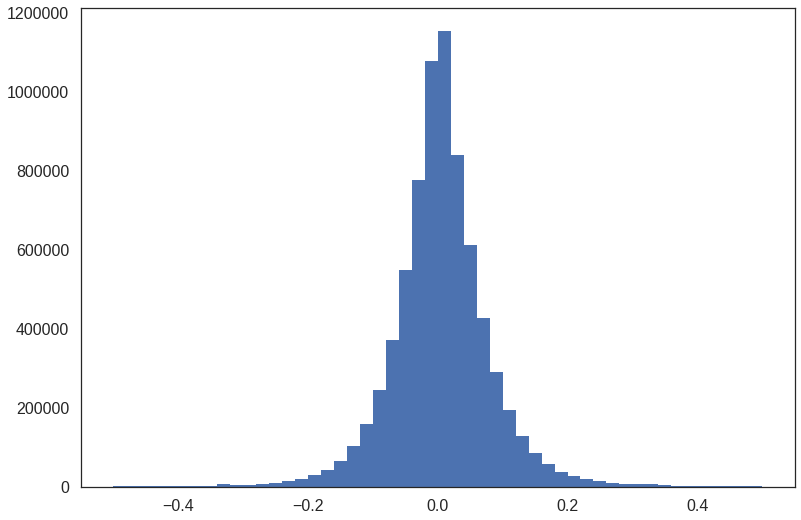

In [152]:
print('histograms for *all* subjects')
subject = np.array([])
for subjectindex in range(len(sub_dirs)):
    s = nib.load('searchlight_maps/searchlight_output_nii/' + sub_dirs[subjectindex] + 'searchlight.nii.gz').get_data()
    subject = np.append(subject, s[s != np.array(None)])

# histogram - value distribution
print('btw-wit')
differences = np.array([cell for cell in subject])
n, bins, patches = plt.hist(differences[~np.isnan(differences)], bins = 50,
                           range = (-.5, .5))
plt.show()

#### (Preparatory Code for Bigger Questions to Come)

In [153]:
# prep code

ROIs = ['V1','fusiform','IT','LOC', 'occitemp',
        'any-roi','whole-brain', 'other']
thresholds = np.arange(0.0, 1.33, .01)
whole_mask = np.ones((94, 94, 72))
abovecounts = np.zeros((len(sub_dirs), len(ROIs), len(thresholds)))
allcounts = np.zeros((len(sub_dirs), len(ROIs), len(thresholds)))

for s in range(len(sub_dirs)):
    subject = sub_dirs[s]
    
    # load subject data
    subject_data = nib.load('searchlight_maps/searchlight_output_nii/' + subject + 'searchlight.nii.gz').get_data()
    
    # generate masks for "extra" rois
    any_mask = load_roi_mask_combined(subject, 1, ROIs[0])
    for roi in ROIs[1:5]:
        any_mask = np.logical_or(any_mask,
                                    load_roi_mask_combined(subject, 1, roi))
    other_mask = np.logical_not(any_mask)
    
    # loop through rois
    for r in range(len(ROIs)):
        roi = ROIs[r]
        
        # mask data depending on roi
        if roi == 'whole-brain':
            data = subject_data[whole_mask==1]
        elif roi == 'other':
            data = subject_data[other_mask==1]
        elif roi == 'any-roi':
            data = subject_data[any_mask==1]
        else:
            roi_mask = load_roi_mask_combined(subject, 1, roi)
            data = subject_data[roi_mask==1]
            
        # compute btw-wit for masked data
        data = data[data != np.array(None)]
        differences = np.array([cell for cell in data])
        
        # loop through thresholds
        for t in range(len(thresholds)):
            threshold = thresholds[t]
            abovecounts[s][r][t] = np.sum(differences > threshold)
            allcounts[s][r][t] = np.size(differences[~np.isnan(differences)])

### What are the proportions of voxels in each ROI with greater within-object similarity than between-object similarity (i.e, btw-wit > 0)?

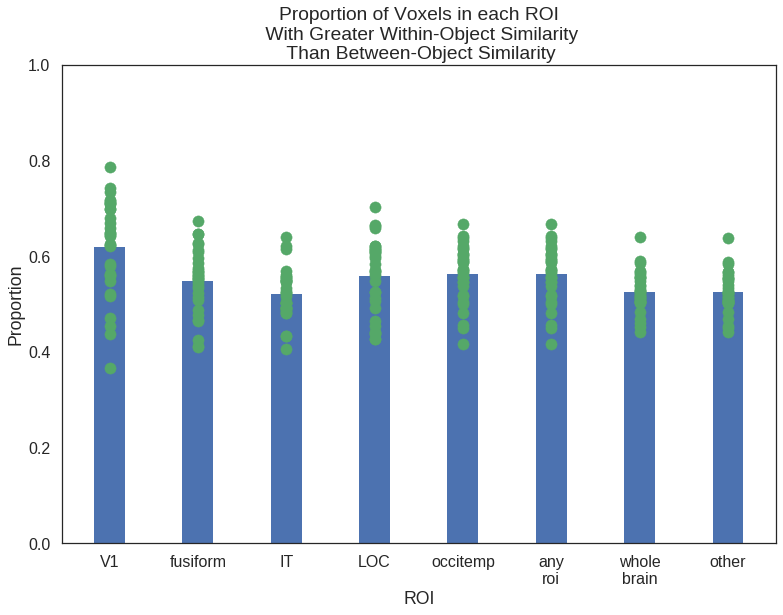

In [154]:
# visualization: proportion of above threshold voxels in each roi
# prepare scatter plot and bar graph values
x = []
y = []
means = []
for r in range(len(ROIs)):
    total = 0.0
    for s in range(len(sub_dirs)):
        x.append(r)
        proportion = abovecounts[s][r][0]/allcounts[s][r][0]
        y.append(proportion)
        total += proportion
    means.append(total/len(sub_dirs))

# want to start with bar graph of means
plt.bar(np.arange(8), means, .35, zorder=0)
plt.scatter(x, y, zorder=5)
plt.title('Proportion of Voxels in each ROI\n With Greater Within-Object Similarity\n Than Between-Object Similarity')
plt.ylabel('Proportion')
plt.ylim((0, 1))
plt.xlabel('ROI')
plt.xticks(np.arange(8),
           ['V1','fusiform','IT','LOC','occitemp', 'any\nroi', 'whole\nbrain', 'other'])
plt.show()

ROIs have a reliably much higher proportion of above-threshold voxels than either the whole brain or the rest of the brain does as a whole. 

### What proportion of above-threshold voxels are in ROIs?

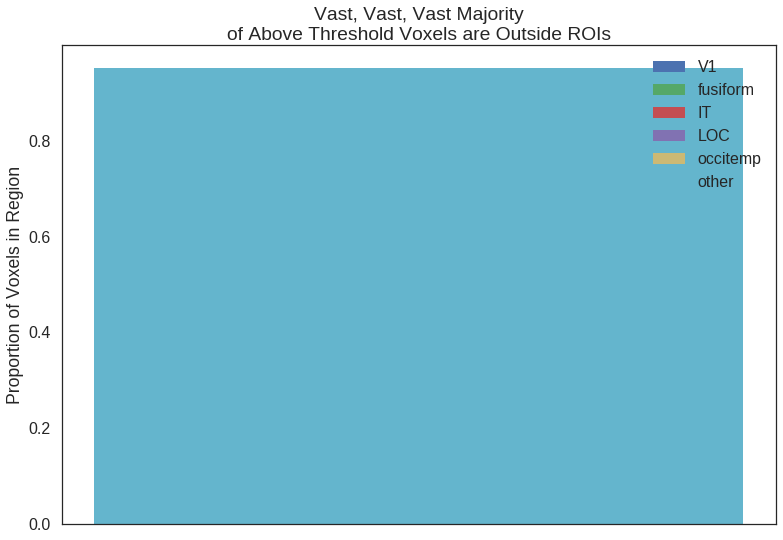

['V1', 'fusiform', 'IT', 'LOC', 'occitemp', 'other']
[ 0.01450345  0.0106311   0.00813919  0.00997713  0.04949653  0.95050347]


In [155]:
# stacked bar graph to represent proportions over the whole brain

# found by dividing each main ROI's abovecounts sum 
# as well as the 'other' abovecounts sum, 
# by the whole-brain's abovecounts sum, then stacking result

# first compute the whole-brain's abovecounts sum
wholesum = 0.0
for s in range(len(sub_dirs)):
    wholesum += abovecounts[s][6][0]

# then loop through relevant ROIs...
means = np.zeros((6))
for r in (np.append(np.arange(0,5), [7])):
    for s in range(len(sub_dirs)):
        if r == 7:
            means[-1] += abovecounts[s][r][0]
        else:
            means[r] += abovecounts[s][r][0]
means = means/wholesum

# finally, graph
restrictedROIs = ['V1', 'fusiform', 'IT', 'LOC', 'occitemp', 'other']
for i in range(len(means)):
    plt.bar([0], [means[i]], label=restrictedROIs[i])
plt.legend()
plt.ylabel('Proportion of Voxels in Region')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off') # labels along the bottom edge are off
plt.title('Vast, Vast, Vast Majority\nof Above Threshold Voxels are Outside ROIs')
plt.show()
print(restrictedROIs)
print(means)

Only 5% of above threshold voxels (with threshold = 0) are in an ROI.

### How does the number of above-threshold voxels change as the threshold increases?

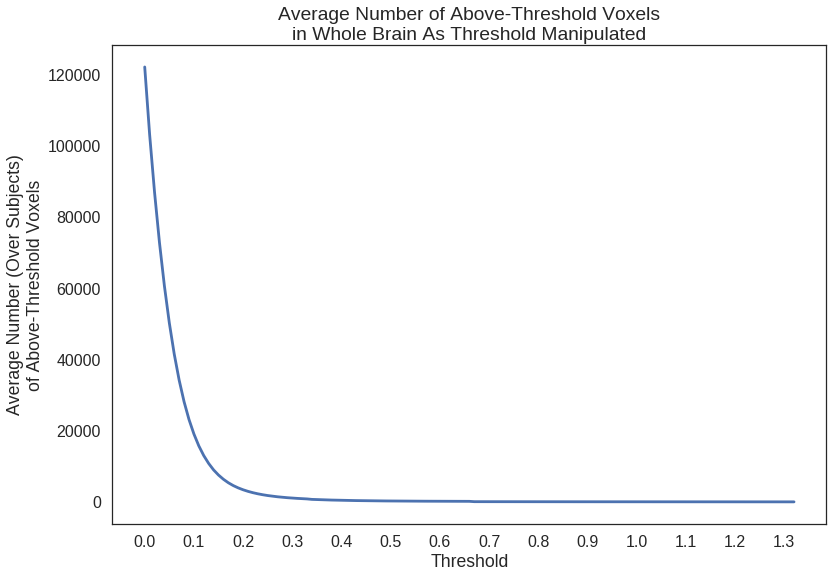

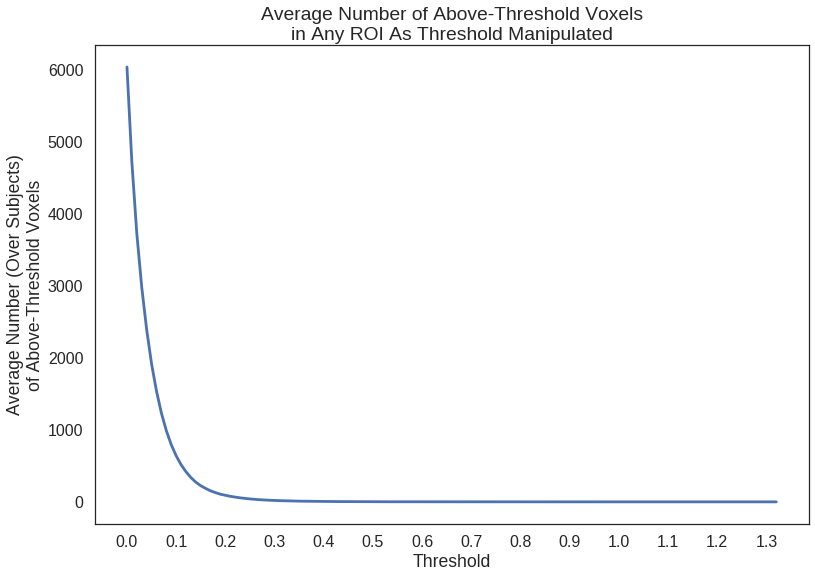

In [156]:
# what happens as threshold is manipulated?
# do the more discriminative voxels cluster in ROIs?

# first check raw numbers - which threshold values matter?
# we want a vector of abovecounts 
# over all T, with ROI 6 (the wholebrain roi), 
# and averaged over subjects
vector = np.zeros((133))
for t in range(len(thresholds)):
    for s in range(len(sub_dirs)):
        vector[t] += abovecounts[s][6][t]

# plot it
plt.plot(vector/len(sub_dirs))
plt.ylabel('Average Number (Over Subjects)\nof Above-Threshold Voxels')
plt.xlabel('Threshold')
plt.xticks(np.arange(0, 133, 10), np.arange(0, 1.33, .1))
plt.title('Average Number of Above-Threshold Voxels\nin Whole Brain As Threshold Manipulated')
plt.show()

# same but for the any-roi roi
vector = np.zeros((133))
for t in range(len(thresholds)):
    for s in range(len(sub_dirs)):
        vector[t] += abovecounts[s][5][t]

plt.plot(vector/len(sub_dirs))
plt.ylabel('Average Number (Over Subjects)\nof Above-Threshold Voxels')
plt.xlabel('Threshold')
plt.xticks(np.arange(0, 133, 10), np.arange(0, 1.33, .1))
plt.title('Average Number of Above-Threshold Voxels\nin Any ROI As Threshold Manipulated')
plt.show()

So only thresholds up to around .2 matter, even within ROIs, as hardly any voxels are above threshold after that. Further graphs will focus on thresholds up to .2

### Do the More Discriminative Voxels Cluster in ROIs?
As threshold increases, how does proportion of above-threshold voxels occurring in ROIs change?

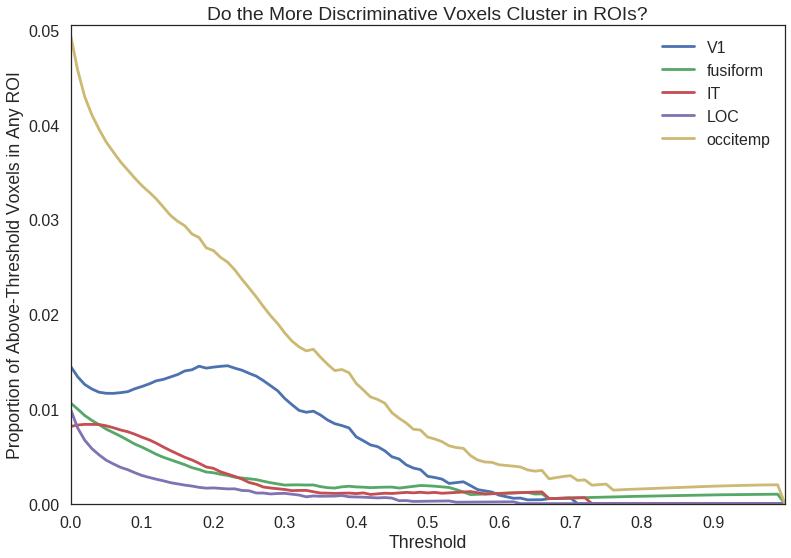

In [157]:
# for every main ROI over every threshold,
# averaging across subjects, 
# plot its abovecounts over whole-brain's abovecounts
courses = np.zeros((6, 133))
for r in np.append(np.arange(0,5), [6]):
    for t in range(len(thresholds)):
        for s in range(len(sub_dirs)):
            if r == 6:
                courses[-1][t] += abovecounts[s][r][t]
            else:
                courses[r][t] += abovecounts[s][r][t]

mainROIs = ['V1', 'fusiform', 'IT', 'LOC', 'occitemp']
for r in range(len(mainROIs)):
    plt.plot(np.divide(courses[r], courses[-1]), label=mainROIs[r])

# setting up axis is work
xrange = 1.0
maxcourse = 4
interval = .1
plt.axis([0, xrange*100, 0, 
          max(np.divide(courses[maxcourse], courses[-1]))+.001])
plt.xticks(np.arange(0, xrange*100, interval*100),
           np.arange(0, xrange, interval))

# rest of stuff
plt.title('Do the More Discriminative Voxels Cluster in ROIs?')
plt.ylabel('Proportion of Above-Threshold Voxels in Any ROI')
plt.xlabel('Threshold')
plt.legend()
plt.show()

Dynamics are more interesting when you focus on and distinguish between the established ROIs.

### Where are above-threshold voxels in the brain?

## Follow-Up

We'll define a new ROI that is the intersection of the set of above-threshold voxels (with threshold = 0) and the occitemp ROI mask (a superset of the other ROIs). And perform using this mask the same analysis performed in the original prepostRSA notebook.

### Similarity Analysis

In [12]:
k = 500

# helper functions
def searchlight_mask(subj,run_num,roi,cope_num,k):

    # load occitemp mask, searchlight data, and subject data
    occitemp = load_roi_mask_combined(subj, run_num, 'occitemp').ravel()
    searchlight = nib.load('searchlight_maps/searchlight_output_nii/' + subj
                           + 'searchlight.nii.gz').get_data().ravel()
    vol = load_single_run_weights(subj,run_num,cope_num)[0].ravel()
    
    # turn searchlight data into a mask
    nandiff = searchlight[~np.isnan(searchlight)]
    diffsize = np.size(nandiff)
    thresh = np.partition(nandiff, diffsize-k)[diffsize-k]
    for i in range(len(searchlight)):
        searchlight[i] = searchlight[i] > thresh
    
    return vol[searchlight==1]

def apply_mask(data,mask):
    return data[mask==1]

def load_data_and_apply_mask(subj,run_num,roi,cope_num,k):
    if roi != 'searchlight':
        vol = load_single_run_weights(subj,run_num,cope_num)[0]
        mask = load_roi_mask_combined(subj,run_num,roi)
        vec = apply_mask(vol,mask)
        return vec
    else:
        return searchlight_mask(subj,run_num,roi,cope_num,k)

def extract_condition_by_voxel_run_mat(this_sub,run_num, roi,k):
    versionNum = coll[this_sub]

    design = [i for i in mdtd if i['version'] == int(versionNum)] # find which axes belong to which condition
    trained = design[0]['trained']
    near = design[0]['near']
    far1 = design[0]['far1']
    far2 = design[0]['far2']

    Tep = getEndpoints(trained)
    Nep = getEndpoints(near)
    condorder = Tep + Nep

    slot1 = load_data_and_apply_mask(
        this_sub,run_num,roi,obj2cope[condorder[0]],k)
    slot2 = load_data_and_apply_mask(
        this_sub,run_num,roi,obj2cope[condorder[1]],k)
    slot3 = load_data_and_apply_mask(
        this_sub,run_num,roi,obj2cope[condorder[2]],k)
    slot4 = load_data_and_apply_mask(
        this_sub,run_num,roi,obj2cope[condorder[3]],k)
    return np.vstack((slot1,slot2,slot3,slot4))

def compare_btw_wit_cond_similarity_across_runs(this_sub,phase,roi,k):
    
    if phase=='pre':
        mat1 = extract_condition_by_voxel_run_mat(this_sub,3,roi,k)
        mat2 = extract_condition_by_voxel_run_mat(this_sub,4,roi,k)
    elif phase=='post':
        mat1 = extract_condition_by_voxel_run_mat(this_sub,5,roi,k)
        mat2 = extract_condition_by_voxel_run_mat(this_sub,6,roi,k)

    fAB = np.vstack((mat1,mat2)) # stack feature matrices
    # square matrix, where off-diagblock is distances *between* 
    # fA and fB vectors
    DAB = pd(fAB, metric='correlation')
    offblock = DAB[:len(mat1),range(len(mat1),shape(DAB)[1])]

    trained_witobj = offblock.diagonal()[:2]
    control_witobj = offblock.diagonal()[2:]
    trained_btwobj = np.array([offblock[:2,:2][0,1], offblock[:2,:2][1,0]])
    control_btwobj = np.array([offblock[2:,2:][0,1],offblock[2:,2:][1,0]])

    trawit_mean = trained_witobj.mean()
    conwit_mean = control_witobj.mean()
    trabtw_mean = trained_btwobj.mean()
    conbtw_mean = control_btwobj.mean()
    return trawit_mean,conwit_mean,trabtw_mean, conbtw_mean 

In [222]:
## Example code block single subject and ROI (searchlight):
this_sub = sub_dirs[0]
run_example = 1
if run_example:
    trawit_mean_pre,conwit_mean_pre,trabtw_mean_pre,conbtw_mean_pre = compare_btw_wit_cond_similarity_across_runs(this_sub,'pre','searchlight',k)
    trawit_mean_post,conwit_mean_post,trabtw_mean_post,conbtw_mean_post = compare_btw_wit_cond_similarity_across_runs(this_sub,'post','searchlight',k)

    tradiff_pre = trabtw_mean_pre - trawit_mean_pre
    condiff_pre = conbtw_mean_pre - conwit_mean_pre

    tradiff_post = trabtw_mean_post - trawit_mean_post
    condiff_post = conbtw_mean_post - conwit_mean_post

    print('Trained Btw-Wit Post-Pre: ' + str(tradiff_post-tradiff_pre))
    print('Control Btw-Wit Post-Pre: ' + str(condiff_post-condiff_pre))  

Trained Btw-Wit Post-Pre: 0.20670637735
Control Btw-Wit Post-Pre: 0.110397744696


In [223]:
### Now compute for all subjects (N=32), and for every ROIs

Tradiffpre = []
Condiffpre = []
Tradiffpost = []
Condiffpost = []

ROIs = ['V1','fusiform','IT','LOC','occitemp', 'searchlight']

for roi in ROIs:
    print(roi)    
    _Tradiffpre = []
    _Condiffpre = []
    _Tradiffpost = []
    _Condiffpost = []
        
    for s in sub_dirs:
        if roi == 'searchlight':
            print(s)
        trawit_mean_pre,conwit_mean_pre, trabtw_mean_pre,conbtw_mean_pre = \
        compare_btw_wit_cond_similarity_across_runs(s,'pre',roi,k)
        trawit_mean_post,conwit_mean_post, trabtw_mean_post,conbtw_mean_post = \
        compare_btw_wit_cond_similarity_across_runs(s,'post',roi,k)
        
        _Tradiffpre.append(trabtw_mean_pre - trawit_mean_pre)
        _Condiffpre.append(conbtw_mean_pre - conwit_mean_pre)

        _Tradiffpost.append(trabtw_mean_post - trawit_mean_post)
        _Condiffpost.append(conbtw_mean_post - conwit_mean_post)
        
    _Tradiffpre,_Condiffpre,_Tradiffpost,_Condiffpost = map(np.array, \
                                                               [_Tradiffpre,_Condiffpre,_Tradiffpost,_Condiffpost])
        
    if len(Tradiffpre)==0:
        Tradiffpre = _Tradiffpre
        Condiffpre = _Condiffpre
        Tradiffpost = _Tradiffpost
        Condiffpost = _Condiffpost
    else:
        Tradiffpre = np.vstack((Tradiffpre,_Tradiffpre))
        Condiffpre = np.vstack((Condiffpre,_Condiffpre))
        Tradiffpost = np.vstack((Tradiffpost,_Tradiffpost))
        Condiffpost = np.vstack((Condiffpost,_Condiffpost))


V1
fusiform
IT
LOC
occitemp
searchlight
0110171_neurosketch
0110172_neurosketch
0111171_neurosketch
0112171_neurosketch
0112172_neurosketch
0112173_neurosketch
0113171_neurosketch
0115172_neurosketch
0115174_neurosketch
0117171_neurosketch
0118171_neurosketch
0118172_neurosketch
0119171_neurosketch
0119172_neurosketch
0119173_neurosketch
0119174_neurosketch
0120171_neurosketch
0120172_neurosketch
0120173_neurosketch
0123171_neurosketch
0123173_neurosketch
0124171_neurosketch
0125171_neurosketch
0125172_neurosketch
1121161_neurosketch
1130161_neurosketch
1202161_neurosketch
1203161_neurosketch
1206161_neurosketch
1206162_neurosketch
1206163_neurosketch
1207162_neurosketch


In [224]:
## save out so you can import later and share
if shape(Tradiffpre)==(len(ROIs),len(sub_dirs)): ## ONLY save out if you've actually finished the analysis above
    with open("prepost_differentiation_by_condition.pkl", 'wb')  as _f:
        cPickle.dump([Tradiffpost,Tradiffpre,Condiffpost,Condiffpre], _f)

In [225]:
# print('Trained Btw-Wit Post-Pre: ' + str(Tradiffpost-Tradiffpre))
# print('Control Btw-Wit Post-Pre: ' + str(Condiffpost-Condiffpre))  

In [226]:
## load in saved pkl
with open('prepost_differentiation_by_condition.pkl', 'rb') as f:
    prepost_diff = cPickle.load(f, encoding='latin1')

### Sensitivity to measuring differences between object representations separately in each phase

In [227]:
## Make sure that the off-diagonal minus on-diagonal elements (btw-within) in each matrix > 0.
## this indicates that the correlation distance between different objects is larger than that between
## measurements of the same object. This needs to be the case for looking at learning to make sense. 

In [228]:
tmp = np.dstack((Tradiffpre,Condiffpre))
Diffpre = tmp.mean(2)

tmp = np.dstack((Tradiffpost,Condiffpost))
Diffpost = tmp.mean(2)

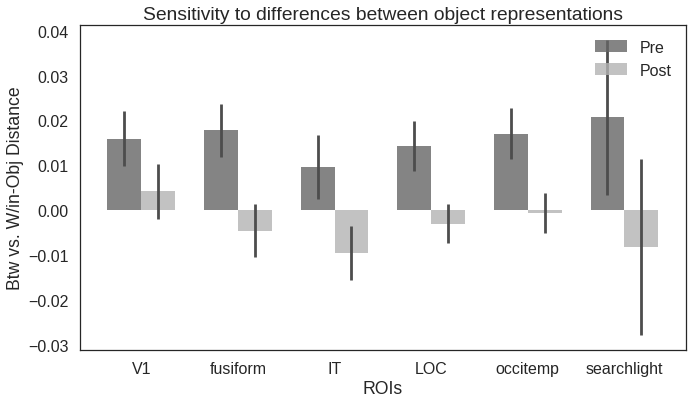

Saving figure to 'plots/object_discriminability_by_roi_group_mean.pdf'...
Done


In [229]:
sns.set_style('white')
sns.set_context('poster')

means_pre = Diffpre.mean(1)
std_pre = Diffpre.std(1)/np.sqrt(shape(Diffpre)[1])

means_post = Diffpost.mean(1)
std_post = Diffpost.std(1)/np.sqrt(shape(Diffpost)[1])

fig, ax = plt.subplots(figsize=(10,6))

n_groups = 6 # num ROIs
index = np.arange(n_groups)
bar_width = 0.35

opacity = 0.8
error_config = {'ecolor': '0.3'}

## plot means as bars
tcolor = (0.4,0.4,0.4)
rects1 = plt.bar(index, means_pre, bar_width,
                 alpha=opacity,
                 color=(0.4,0.4,0.4),
                 yerr=std_pre,
                 error_kw=error_config,
                 label='Pre')

ccolor = (0.7,0.7,0.7)
rects2 = plt.bar(index + bar_width, means_post, bar_width,
                 alpha=opacity,
                 color=(0.7,0.7,0.7),
                 yerr=std_post,
                 error_kw=error_config,
                 label='Post')


plt.xlabel('ROIs')
plt.ylabel('Btw vs. W/in-Obj Distance')
plt.title('Sensitivity to differences between object representations')
plt.xticks(index + bar_width / 2, ('V1','fusiform','IT','LOC','occitemp', 'searchlight'))
plt.legend()
plt.tight_layout()
plt.show()

save_out = 1
if save_out:
    helpers.save('plots/object_discriminability_by_roi_group_mean', ext='pdf', close=False, verbose=True)

### Learning-related changes in representational distance

In [230]:
Tradifflearn = Tradiffpost-Tradiffpre
Condifflearn = Condiffpost-Condiffpre

In [231]:
ROIs = ['V1','fusiform','IT','LOC','occitemp', 'searchlight']
print(Tradifflearn.std(1)/np.sqrt(shape(Tradifflearn)[1]))
print(Condifflearn.mean(1))

[ 0.01155871  0.01024765  0.0102703   0.0087579   0.00835134  0.02748718]
[-0.01165819 -0.02268537 -0.03286402 -0.02582566 -0.02128899 -0.01961508]


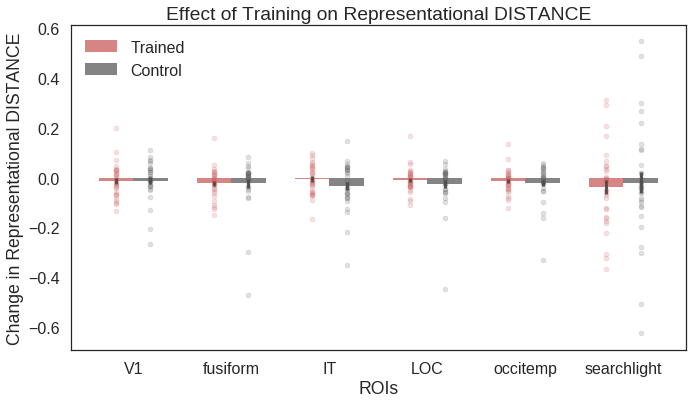

Saving figure to 'plots/differentiation_by_roi_indiv_sub.pdf'...
Done


In [232]:
## Generate summary plot (main analysis)

plot_indiv_subs = 1

sns.set_style('white')
sns.set_context('poster')
means_trained = Tradifflearn.mean(1)
std_trained = Tradifflearn.std(1)/np.sqrt(shape(Tradifflearn)[1])

means_control = Condifflearn.mean(1)
std_control = Condifflearn.std(1)/np.sqrt(shape(Condifflearn)[1])


fig, ax = plt.subplots(figsize=(10,6))

n_groups = 6 # num ROIs
index = np.arange(n_groups)
bar_width = 0.35

opacity = 0.8
error_config = {'ecolor': '0.3'}

## plot means as bars
tcolor = (0.8,0.4,0.4)
rects1 = plt.bar(index, means_trained, bar_width,
                 alpha=opacity,
                 color=(0.8,0.4,0.4),
                 yerr=std_trained,
                 error_kw=error_config,
                 label='Trained')

ccolor = (0.4,0.4,0.4)
rects2 = plt.bar(index + bar_width, means_control, bar_width,
                 alpha=opacity,
                 color=(0.4,0.4,0.4),
                 yerr=std_control,
                 error_kw=error_config,
                 label='Control')

if plot_indiv_subs:
    ## now plot individual subjects as dots
    def generate_concat_tiled(array,reps):        
        inds = []
        for i in index:
            inds.append(np.tile(i,reps))
        return np.reshape(np.array(inds),(1,reps*len(array)))

    tindex = generate_concat_tiled(index,len(Tradifflearn[0]))
    tsubdists = np.reshape(Tradifflearn,(1,shape(Tradifflearn)[0]*shape(Tradifflearn)[1]))
    plt.scatter(tindex,tsubdists,s=25,alpha=0.2,color=tcolor)

    cindex = generate_concat_tiled(index,len(Condifflearn[0]))+bar_width
    csubdists = np.reshape(Condifflearn,(1,shape(Condifflearn)[0]*shape(Condifflearn)[1]))
    plt.scatter(cindex,csubdists,s=25,alpha=0.2,color=ccolor)

plt.xlabel('ROIs')
plt.ylabel('Change in Representational DISTANCE')
plt.title('Effect of Training on Representational DISTANCE')
plt.xticks(index + bar_width / 2, ('V1','fusiform','IT','LOC','occitemp', 'searchlight'))
plt.legend()
plt.tight_layout()
plt.show()

save_out = 1
if save_out:
    if plot_indiv_subs:
        helpers.save('plots/differentiation_by_roi_indiv_sub', ext='pdf', close=False, verbose=True)
    else:
        helpers.save('plots/differentiation_by_roi_group_mean', ext='pdf', close=False, verbose=True)

In [262]:
# vary k and map the changes
### Now compute for all subjects (N=32), and for every ROIs

Tradiffpre = []
Condiffpre = []
Tradiffpost = []
Condiffpost = []

trainedline = []
controlline = []

ROIs = ['V1','fusiform','IT','LOC','occitemp', 'searchlight']

for k in np.arange(100, 10000, 100)[:26][::-1]:
    ### Now compute for all subjects (N=32), and for every ROIs

    Tradiffpre = []
    Condiffpre = []
    Tradiffpost = []
    Condiffpost = []

    ROIs = ['V1','fusiform','IT','LOC','occitemp', 'searchlight']

    for roi in ROIs:
        print(roi)    
        _Tradiffpre = []
        _Condiffpre = []
        _Tradiffpost = []
        _Condiffpost = []

        for s in sub_dirs:
            if roi == 'searchlight':
                print(s)
            trawit_mean_pre,conwit_mean_pre, trabtw_mean_pre,conbtw_mean_pre = \
            compare_btw_wit_cond_similarity_across_runs(s,'pre',roi,k)
            trawit_mean_post,conwit_mean_post, trabtw_mean_post,conbtw_mean_post = \
            compare_btw_wit_cond_similarity_across_runs(s,'post',roi,k)

            _Tradiffpre.append(trabtw_mean_pre - trawit_mean_pre)
            _Condiffpre.append(conbtw_mean_pre - conwit_mean_pre)

            _Tradiffpost.append(trabtw_mean_post - trawit_mean_post)
            _Condiffpost.append(conbtw_mean_post - conwit_mean_post)

        _Tradiffpre,_Condiffpre,_Tradiffpost,_Condiffpost = map(np.array, \
                                                                   [_Tradiffpre,_Condiffpre,_Tradiffpost,_Condiffpost])

        if len(Tradiffpre)==0:
            Tradiffpre = _Tradiffpre
            Condiffpre = _Condiffpre
            Tradiffpost = _Tradiffpost
            Condiffpost = _Condiffpost
        else:
            Tradiffpre = np.vstack((Tradiffpre,_Tradiffpre))
            Condiffpre = np.vstack((Condiffpre,_Condiffpre))
            Tradiffpost = np.vstack((Tradiffpost,_Tradiffpost))
            Condiffpost = np.vstack((Condiffpost,_Condiffpost))
    
    Tradifflearn = Tradiffpost-Tradiffpre
    Condifflearn = Condiffpost-Condiffpre
    means_trained = Tradifflearn.mean(1)
    means_control = Condifflearn.mean(1)
    trainedline = [means_trained[-1]] + trainedline
    controlline = [means_control[-1]] + controlline

V1
fusiform
IT
LOC
occitemp
searchlight
0110171_neurosketch
0110172_neurosketch
0111171_neurosketch
0112171_neurosketch
0112172_neurosketch
0112173_neurosketch
0113171_neurosketch
0115172_neurosketch
0115174_neurosketch
0117171_neurosketch
0118171_neurosketch
0118172_neurosketch
0119171_neurosketch
0119172_neurosketch
0119173_neurosketch
0119174_neurosketch
0120171_neurosketch
0120172_neurosketch
0120173_neurosketch
0123171_neurosketch
0123173_neurosketch
0124171_neurosketch
0125171_neurosketch
0125172_neurosketch
1121161_neurosketch
1130161_neurosketch
1202161_neurosketch
1203161_neurosketch
1206161_neurosketch
1206162_neurosketch
1206163_neurosketch
1207162_neurosketch
V1
fusiform
IT
LOC
occitemp
searchlight
0110171_neurosketch
0110172_neurosketch
0111171_neurosketch
0112171_neurosketch
0112172_neurosketch
0112173_neurosketch
0113171_neurosketch
0115172_neurosketch
0115174_neurosketch
0117171_neurosketch
0118171_neurosketch
0118172_neurosketch
0119171_neurosketch
0119172_neurosketch


KeyboardInterrupt: 

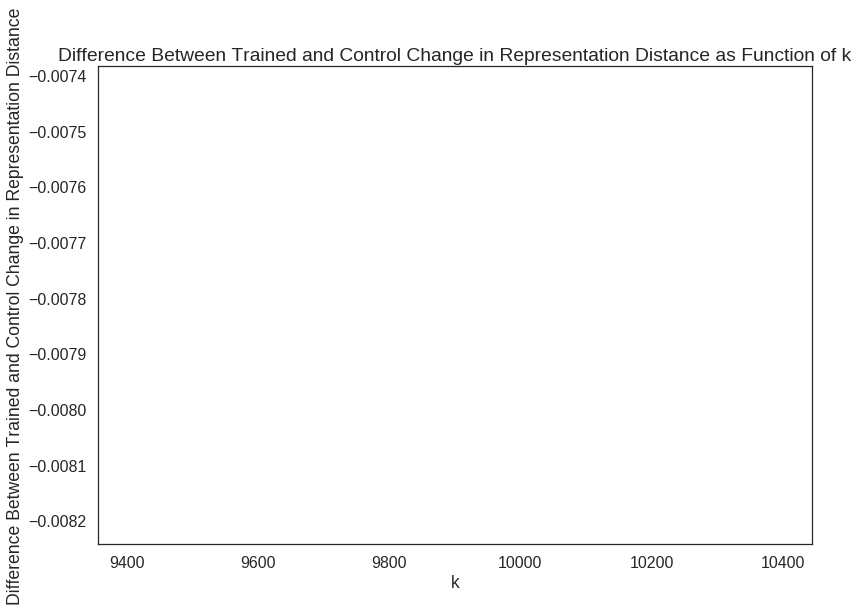

In [264]:
plt.plot(np.arange(100, 10000, 100)[99-len(trainedline):], np.array(trainedline)-np.array(controlline))
plt.xlabel('k')
plt.ylabel('Difference Between Trained and Control Change in Representation Distance')
plt.title('Difference Between Trained and Control Change in Representation Distance as Function of k')
plt.show()

## How does varying searchlight radius impact results?

In [13]:
### Now compute for all subjects (N=32), and for every ROIs

Tradiffpre = []
Condiffpre = []
Tradiffpost = []
Condiffpost = []

ROIs = ['occitemp', '1', '3', '5']

for roi in ROIs:
    print(roi)
    if roi != 'occitemp':
        searchlight_over_each(sub_dirs, int(roi))
    _Tradiffpre = []
    _Condiffpre = []
    _Tradiffpost = []
    _Condiffpost = []
        
    for s in sub_dirs:
        if roi != 'occitemp':
            trawit_mean_pre,conwit_mean_pre, trabtw_mean_pre,conbtw_mean_pre = \
            compare_btw_wit_cond_similarity_across_runs(s,'pre','searchlight',k)
            trawit_mean_post,conwit_mean_post, trabtw_mean_post,conbtw_mean_post = \
            compare_btw_wit_cond_similarity_across_runs(s,'post','searchlight',k)
        else:
            trawit_mean_pre,conwit_mean_pre, trabtw_mean_pre,conbtw_mean_pre = \
            compare_btw_wit_cond_similarity_across_runs(s,'pre','occitemp',k)
            trawit_mean_post,conwit_mean_post, trabtw_mean_post,conbtw_mean_post = \
            compare_btw_wit_cond_similarity_across_runs(s,'post','occitemp',k)
        
        _Tradiffpre.append(trabtw_mean_pre - trawit_mean_pre)
        _Condiffpre.append(conbtw_mean_pre - conwit_mean_pre)

        _Tradiffpost.append(trabtw_mean_post - trawit_mean_post)
        _Condiffpost.append(conbtw_mean_post - conwit_mean_post)
        
    _Tradiffpre,_Condiffpre,_Tradiffpost,_Condiffpost = map(np.array, \
                                                               [_Tradiffpre,_Condiffpre,_Tradiffpost,_Condiffpost])
        
    if len(Tradiffpre)==0:
        Tradiffpre = _Tradiffpre
        Condiffpre = _Condiffpre
        Tradiffpost = _Tradiffpost
        Condiffpost = _Condiffpost
    else:
        Tradiffpre = np.vstack((Tradiffpre,-_Tradiffpre))
        Condiffpre = np.vstack((Condiffpre,_Condiffpre))
        Tradiffpost = np.vstack((Tradiffpost,_Tradiffpost))
        Condiffpost = np.vstack((Condiffpost,_Condiffpost))

occitemp
1
0110171_neurosketch
0110172_neurosketch
0111171_neurosketch
0112171_neurosketch
0112172_neurosketch
0112173_neurosketch
0113171_neurosketch
0115172_neurosketch
0115174_neurosketch
0117171_neurosketch
0118171_neurosketch
0118172_neurosketch
0119171_neurosketch
0119172_neurosketch
0119173_neurosketch
0119174_neurosketch
0120171_neurosketch
0120172_neurosketch
0120173_neurosketch
0123171_neurosketch
0123173_neurosketch
0124171_neurosketch
0125171_neurosketch
0125172_neurosketch
1121161_neurosketch
1130161_neurosketch
1202161_neurosketch
1203161_neurosketch
1206161_neurosketch
1206162_neurosketch
1206163_neurosketch
1207162_neurosketch
3
0110171_neurosketch
0110172_neurosketch
0111171_neurosketch
0112171_neurosketch
0112172_neurosketch
0112173_neurosketch
0113171_neurosketch
0115172_neurosketch
0115174_neurosketch
0117171_neurosketch
0118171_neurosketch
0118172_neurosketch
0119171_neurosketch
0119172_neurosketch
0119173_neurosketch
0119174_neurosketch
0120171_neurosketch
0120172

### Sensitivity to measuring differences between object representations separately in each phase

In [14]:
## Make sure that the off-diagonal minus on-diagonal elements (btw-within) in each matrix > 0.
## this indicates that the correlation distance between different objects is larger than that between
## measurements of the same object. This needs to be the case for looking at learning to make sense. 

In [16]:
tmp = np.dstack((Tradiffpre,Condiffpre))
Diffpre = tmp.mean(2)

tmp = np.dstack((Tradiffpost,Condiffpost))
Diffpost = tmp.mean(2)

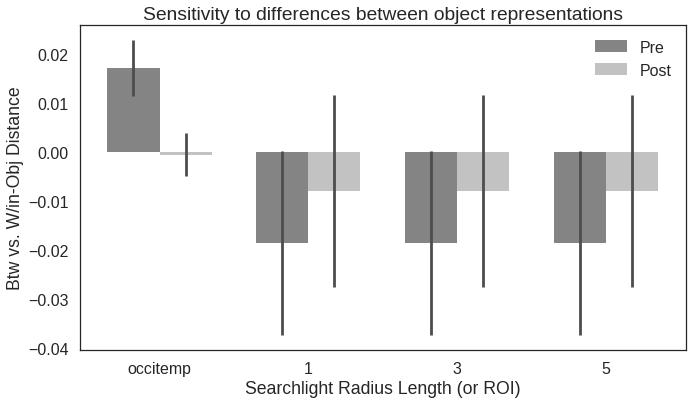

Saving figure to 'plots/object_discriminability_by_searchlight_roi_radii.pdf'...
Done


In [17]:
sns.set_style('white')
sns.set_context('poster')

means_pre = Diffpre.mean(1)
std_pre = Diffpre.std(1)/np.sqrt(shape(Diffpre)[1])

means_post = Diffpost.mean(1)
std_post = Diffpost.std(1)/np.sqrt(shape(Diffpost)[1])

fig, ax = plt.subplots(figsize=(10,6))

n_groups = 4 # num ROIs
index = np.arange(n_groups)
bar_width = 0.35

opacity = 0.8
error_config = {'ecolor': '0.3'}

## plot means as bars
tcolor = (0.4,0.4,0.4)
rects1 = plt.bar(index, means_pre, bar_width,
                 alpha=opacity,
                 color=(0.4,0.4,0.4),
                 yerr=std_pre,
                 error_kw=error_config,
                 label='Pre')

ccolor = (0.7,0.7,0.7)
rects2 = plt.bar(index + bar_width, means_post, bar_width,
                 alpha=opacity,
                 color=(0.7,0.7,0.7),
                 yerr=std_post,
                 error_kw=error_config,
                 label='Post')


plt.xlabel('Searchlight Radius Length (or ROI)')
plt.ylabel('Btw vs. W/in-Obj Distance')
plt.title('Sensitivity to differences between object representations')
plt.xticks(index + bar_width / 2, ('occitemp', '1','3','5'))
plt.legend()
plt.tight_layout()
plt.show()

save_out = 1
if save_out:
    helpers.save('plots/object_discriminability_by_searchlight_roi_radii', ext='pdf', close=False, verbose=True)

### Learning-related changes in representational distance

In [18]:
Tradifflearn = Tradiffpost-Tradiffpre
Condifflearn = Condiffpost-Condiffpre

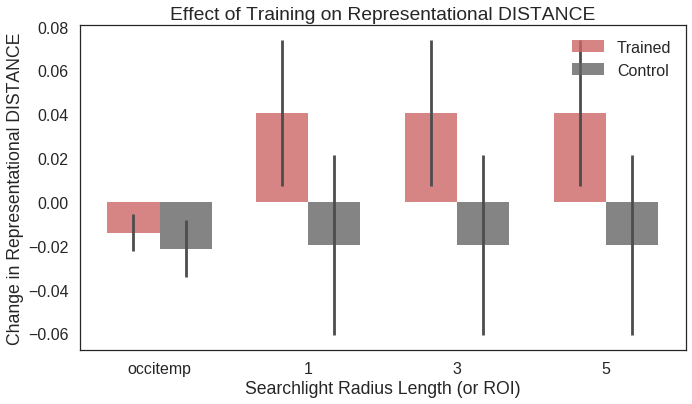

Saving figure to 'plots/differentiation_by_radii_indiv_sub.pdf'...
Done
[ 0.00835134  0.03319658  0.03319658  0.03319658]
[-0.02128899 -0.01961508 -0.01961508 -0.01961508]


In [19]:
ROIs = ['occitemp', '1','3', '5'] ## Generate summary plot (main analysis)

plot_indiv_subs = 1

sns.set_style('white')
sns.set_context('poster')
means_trained = Tradifflearn.mean(1)
std_trained = Tradifflearn.std(1)/np.sqrt(shape(Tradifflearn)[1])

means_control = Condifflearn.mean(1)
std_control = Condifflearn.std(1)/np.sqrt(shape(Condifflearn)[1])


fig, ax = plt.subplots(figsize=(10,6))

n_groups = 4 # num ROIs
index = np.arange(n_groups)
bar_width = 0.35

opacity = 0.8
error_config = {'ecolor': '0.3'}

## plot means as bars
tcolor = (0.8,0.4,0.4)
rects1 = plt.bar(index, means_trained, bar_width,
                 alpha=opacity,
                 color=(0.8,0.4,0.4),
                 yerr=std_trained,
                 error_kw=error_config,
                 label='Trained')

ccolor = (0.4,0.4,0.4)
rects2 = plt.bar(index + bar_width, means_control, bar_width,
                 alpha=opacity,
                 color=(0.4,0.4,0.4),
                 yerr=std_control,
                 error_kw=error_config,
                 label='Control')

if plot_indiv_subs:
    ## now plot individual subjects as dots
    def generate_concat_tiled(array,reps):        
        inds = []
        for i in index:
            inds.append(np.tile(i,reps))
        return np.reshape(np.array(inds),(1,reps*len(array)))

    tindex = generate_concat_tiled(index,len(Tradifflearn[0]))
    tsubdists = np.reshape(Tradifflearn,(1,shape(Tradifflearn)[0]*shape(Tradifflearn)[1]))
    #plt.scatter(tindex,tsubdists,s=25,alpha=0.2,color=tcolor)

    cindex = generate_concat_tiled(index,len(Condifflearn[0]))+bar_width
    csubdists = np.reshape(Condifflearn,(1,shape(Condifflearn)[0]*shape(Condifflearn)[1]))
    #plt.scatter(cindex,csubdists,s=25,alpha=0.2,color=ccolor)

plt.xlabel('Searchlight Radius Length (or ROI)')
plt.ylabel('Change in Representational DISTANCE')
plt.title('Effect of Training on Representational DISTANCE')
plt.xticks(index + bar_width / 2, ('occitemp', '1','3','5'))
plt.legend()
plt.tight_layout()
plt.show()

save_out = 1
if save_out:
    if plot_indiv_subs:
        helpers.save('plots/differentiation_by_radii_indiv_sub', ext='pdf', close=False, verbose=True)
    else:
        helpers.save('plots/differentiation_by_radii_group_mean', ext='pdf', close=False, verbose=True)
print(Tradifflearn.std(1)/np.sqrt(shape(Tradifflearn)[1]))
print(Condifflearn.mean(1))

In [310]:
Condifflearn.mean(1)

array([-0.02128899, -0.01961508, -0.01961508, -0.01961508, -0.01961508,
       -0.01961508, -0.01961508, -0.01961508])